In [1]:
%matplotlib notebook

import random

import numpy as np

from environment import Easy21Environment, Easy21State

import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

## Monte-Carlo Agent

In [19]:
class MonteCarloAgent():
    def __init__( self ):
        # Params
        self.n_0 = 100000
        self.total_episodes = 2 ** 16

        # Globals
        self.env = Easy21Environment()

        # Vars
        state_action_space = list( self.env.getStateSpace() ) + [ self.env.getActionSpace() ]
        print( state_action_space )
        self.visits = np.zeros( state_action_space )
        self.q_estimate = np.zeros( state_action_space )
        self.actions = self.env.getActionSpace()

    def getStateVisits( self, state ):
        """
        Sum over actions for state
        """
        return np.sum( self.visits[ tuple( state ) ] )

    def getEpsilon( self, state ):
        state_visits = self.getStateVisits( state )
        return self.n_0 / ( self.n_0 + state_visits )

    def epsilonGreedy( self, state, should_print=False ):
        epsilon = self.getEpsilon( state )
        if( random.random() > epsilon ): # Act greedy 
            return self.q_estimate[ tuple( state ) ].argmax()
        else:
            if should_print:
                print( epsilon )
                print( "Exploring" )
            return random.randint( 0, self.actions-1 )

    def getStep( self, state ):
        return 1 / self.visits[ tuple( state ) ]

    def train( self ):
        training_total_wins = 0
        for i in range( self.total_episodes ):
            # Run Episode
            state = Easy21State()
            used_state_actions = []
            total_reward = 0
            while not state.terminal:
                action = self.epsilonGreedy( state.state() )
                used_state_actions.append( np.append( state.state(), action ) )
                state, reward = self.env.step( state, action )
                total_reward += reward

            if total_reward == 1:
                training_total_wins += 1

            # Learn
            for used_state_action in used_state_actions:
                self.visits[ tuple( used_state_action ) ] += 1
                estimate = self.q_estimate[ tuple( used_state_action ) ]
                error = total_reward - estimate
                step = self.getStep( used_state_action )
                new_estimate = estimate + error * step
                self.q_estimate[ tuple( used_state_action ) ] = new_estimate

        return training_total_wins / self.total_episodes

mca = MonteCarloAgent()

mca.n_0 = 100
mca.total_episodes = 50000

for i in range( 10 ):
    mca.train()

[10, 21, 2]


<IPython.core.display.Javascript object>


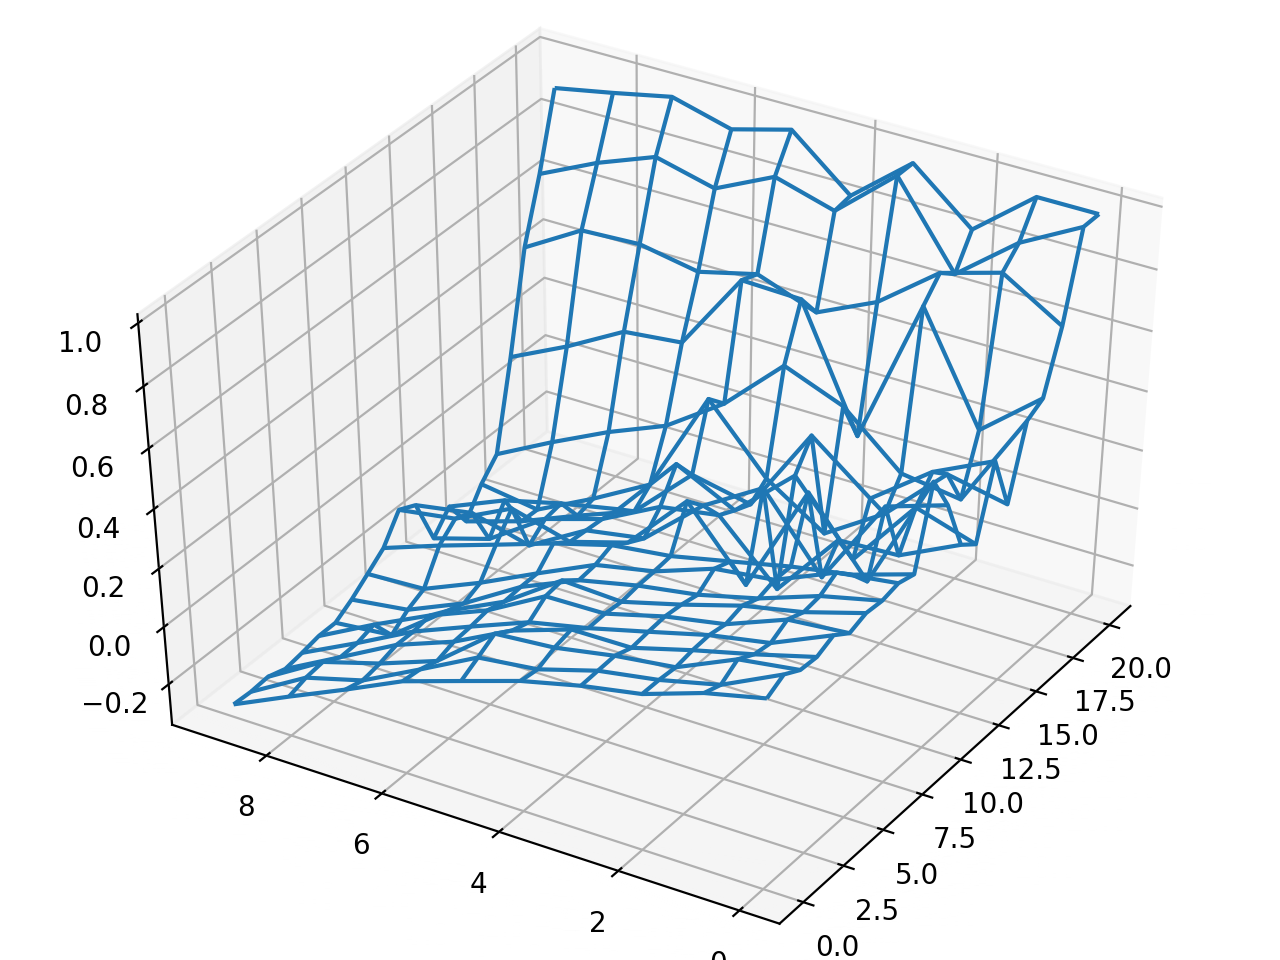

<IPython.core.display.Javascript object>


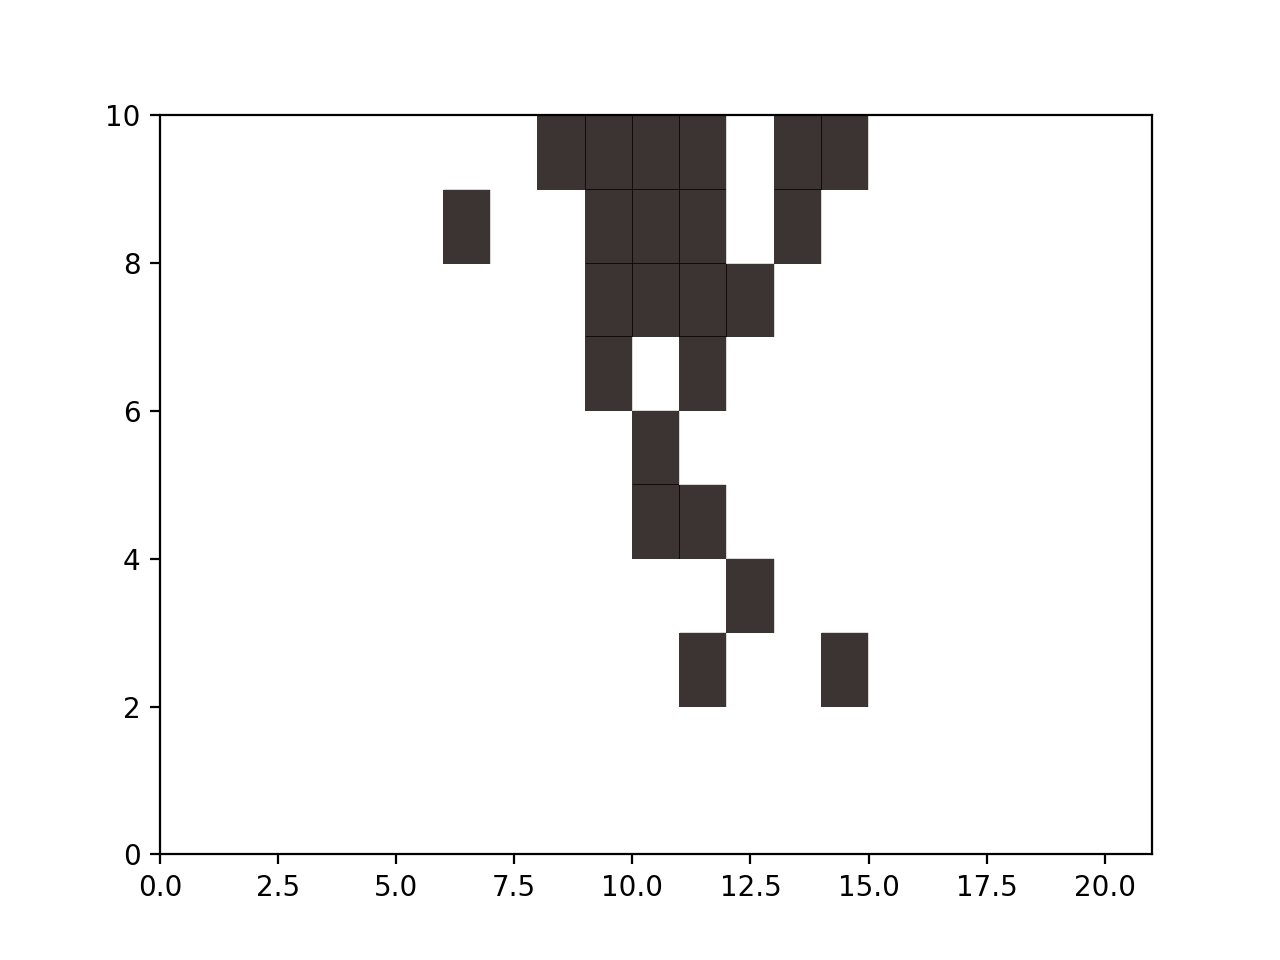

<IPython.core.display.Javascript object>


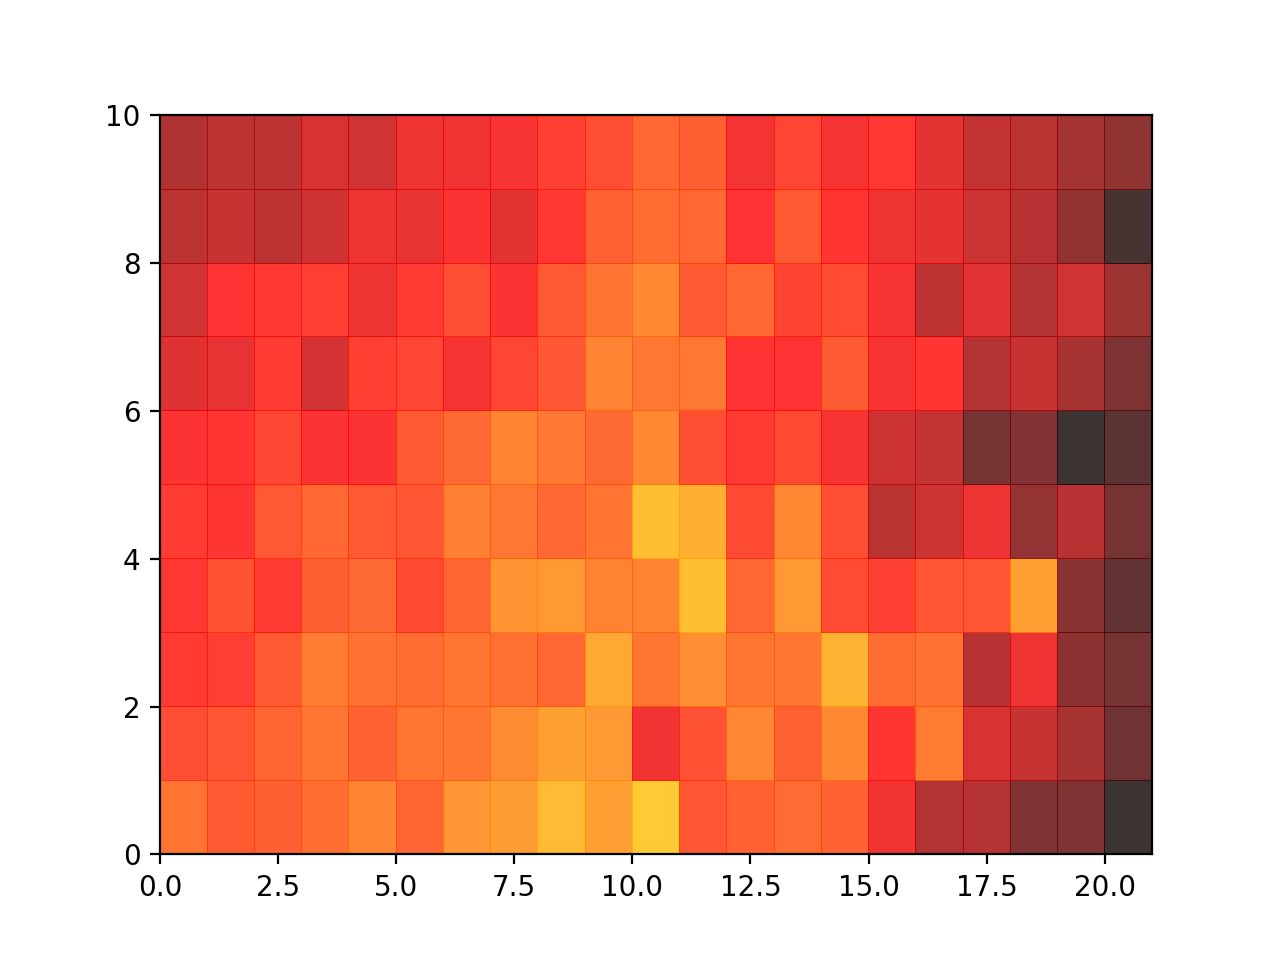

<IPython.core.display.Javascript object>


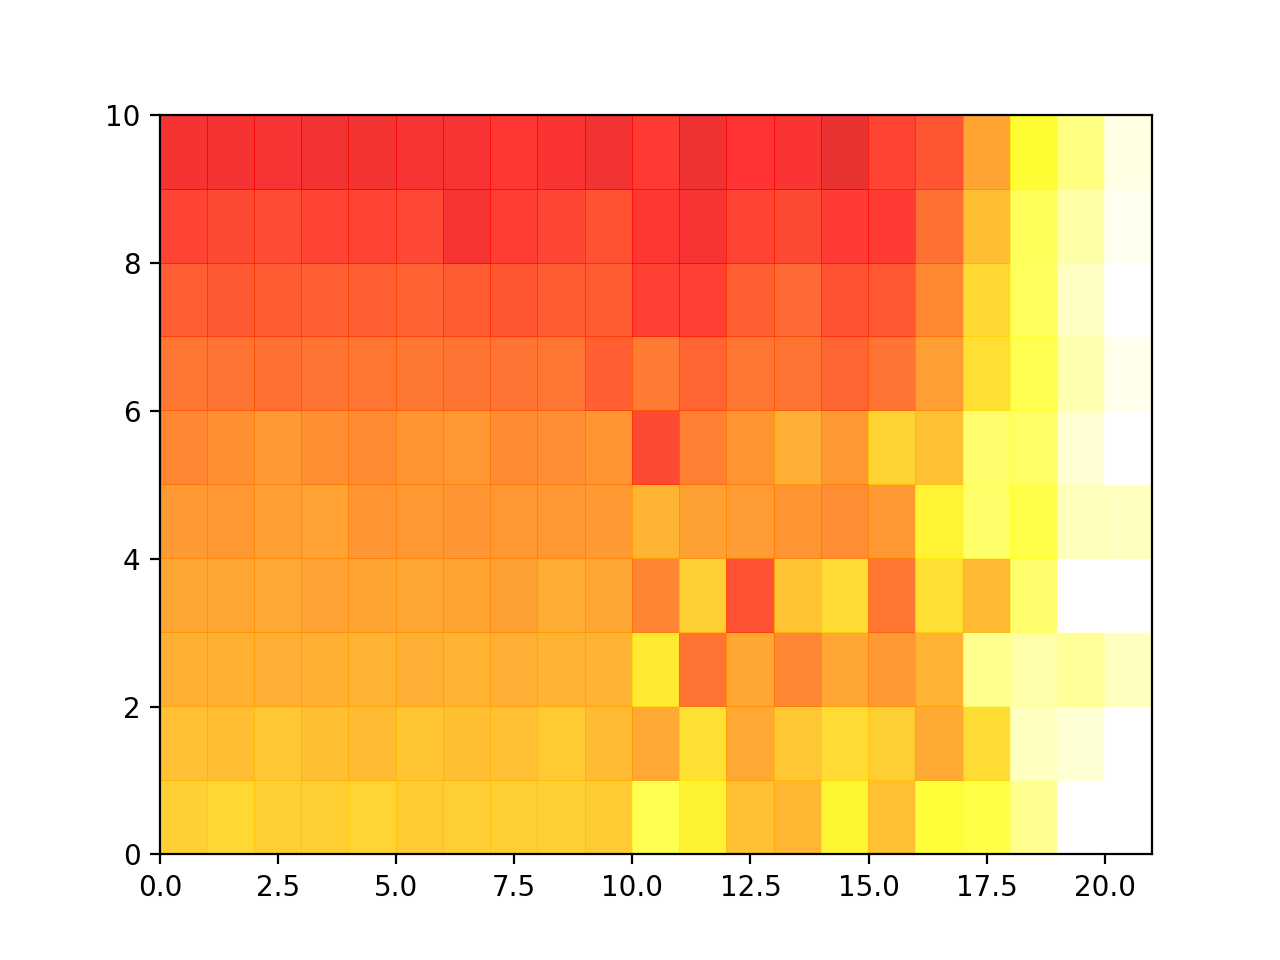

In [22]:
def plot( z ):
    x = range( z.shape[ 1 ] )
    y = range( z.shape[ 0 ] )
    X, Y = np.meshgrid( x, y )
    
    fig = plt.figure()
    ax = Axes3D( fig )
    ax.plot_wireframe( X, Y, z )

plot( np.max( mca.q_estimate, axis=2 ) )

fig, ax = plt.subplots()
ax.pcolor(np.argmax( mca.q_estimate, axis=2 ), cmap=plt.cm.hot, alpha=0.8)
fig, ax = plt.subplots()
ax.pcolor(mca.q_estimate[:, :, 0], cmap=plt.cm.hot, alpha=0.8, vmin=-1, vmax=1)
fig, ax = plt.subplots()
ax.pcolor(mca.q_estimate[:, :, 1], cmap=plt.cm.hot, alpha=0.8, vmin=-1, vmax=1)

## Sansa(Lambda)

